# [Boyin] 

In [9]:
%reload_ext autoreload
%autoreload 2

import sys, os
sys.path.insert(0, './cocoapi/PythonAPI')
sys.path.insert(0, './cocoapi/PythonAPI/pycocotools')
sys.path.insert(0, '/home/zhurui/anaconda2/lib/python2.7/site-packages')

# from IPython.core.display import display, HTML
# display(HTML("<style>.container { width:90% !important; }</style>"))

sys.path.insert(0, './renderer')
sys.path.insert(0, '../')

from collections import namedtuple
import render_car_instances as rci
import utils.utils as uts
import glob
import os

import numpy as np
np.set_printoptions(threshold=np.nan)
import matplotlib.pyplot as plt
%matplotlib inline

import ntpath
pattern = '*%s*.%s' % ('_Camera_', 'jpg')

# [Boyin] Write pose maps to .npy files

In [10]:
codes_path = '/home/zhurui/Documents/mesh-voxelization/models/cars_64/codes.npy'
codes = np.load(codes_path)

print codes.shape
print np.amax(codes, axis=1)
print np.amin(codes, axis=1)

(10, 79)
[194.10701892  52.3540656   36.48827657  38.21597123  30.67944249
  28.11925775  20.46198426  19.39282606  14.72781895  15.88235606]
[-130.94684662  -48.79492285  -27.47333481  -33.49253033  -12.43573312
  -17.21450101  -13.24829926  -15.7550083   -12.31628475  -13.42541076]


# Clean combined dataset

In [ ]:
unique_lists = []
for split in ['train', 'val']:
    list_path = '/home/zhurui/Documents/deeplab/datasets/apolloscape/combined/train/split_dup/%s.txt'%split
    with open(list_path) as f:
        content = f.readlines()
    # you may also want to remove whitespace characters like `\n` at the end of each line
    content = [x.strip() for x in content]
    print len(content)
    unique_content = list(set(content))
    print len(unique_content)
    
    unique_lists.append(unique_content)

def intersection(lst1, lst2):
    return list(set(lst1) & set(lst2))
print len(intersection(unique_lists[0], unique_lists[1]))

final_lists = {}
final_lists['train'] = list(set(unique_lists[0]) - set(unique_lists[1]))
final_lists['val'] = unique_lists[1]
print len(final_lists['train']), len(final_lists['val'])

for split in ['train', 'val']:
    list_path = '/home/zhurui/Documents/deeplab/datasets/apolloscape/combined/train/split/%s.txt'%split
    thefile = open(list_path, 'w')
    for item in final_lists[split]:
      thefile.write("%s\n" % item)

In [ ]:
# Write test set split
apollo__root = '/home/zhurui/Documents/deeplab/datasets/apolloscape/'
test_dir = apollo__root + 'combined/test/images'
pattern = '*%s*.%s' % ('_Camera_', 'jpg')

def get_json(json_dir):
    search_files = os.path.join(json_dir, pattern)
    filenames = sorted(glob.glob(search_files))
    return [ntpath.basename(filename) for filename in filenames]

jsons_res = get_json(test_dir)
list_path = '/home/zhurui/Documents/deeplab/datasets/apolloscape/combined/train/split/test.txt'
thefile = open(list_path, 'w')
for item in jsons_res:
    thefile.write("%s\n" % item)
    print item
print len(jsons_res)

In [ ]:
# Demo readling pkl and off files
import pickle as pkl
file_path = '/home/zhurui/Documents/baidu/personal-code/car-fitting/rui_modelfitting/dataset-api/apolloscape/combined/train/car_models/019-SUV.pkl'
with open(file_path) as f:
    a = pkl.load(f)
print a.keys()
# print a['vertices'].shape, a['faces'].shape
# print np.amax(a['vertices'], axis=0), np.amin(a['vertices'], axis=0)

off_path = '/home/zhurui/Documents/mesh-voxelization/models/cars/2_watertight/mc/019-SUV_ori_scale.off'
from off_utils import Mesh
off = Mesh.from_off(off_path)
print off.vertices.shape, off.faces.shape
print np.amax(off.vertices, axis=0), np.amin(off.vertices, axis=0)
print np.amax(off.faces), np.amin(off.faces)

# Batch processing

## For testing: process masks

In [ ]:
from mask import decode
import pickle
import scipy.misc
from PIL import Image
from scipy.io import savemat

det_masks_path = '../apolloscape/combined/test/det_masks'
ignore_masks_path = '../apolloscape/combined/test/ignore_mask'
image_path = '../apolloscape/combined/test/images'
seg_output_path = '../apolloscape/combined/test/pose_maps_02'

pattern = '*%s*.%s' % ('_Camera_', 'pkl')
search_files = os.path.join(det_masks_path, pattern)
filenames = sorted(glob.glob(search_files))
print len(filenames)

def _iou(res, gt):
    overlap = (res==1.) * (gt==1.)
    iou = np.sum(overlap) / np.sum(res)
    return iou

def resize_02(img, shape_out, if_binary=False):
    im_reshaped = scipy.misc.imresize(img, (shape_out[0], shape_out[1]), 'nearest')
    if if_binary:
        return im_reshaped / 255.
    else:
        return im_reshaped

shape_ori = [2710, 3384]
shape_02 = [544, 680]
mask_cam05 = np.zeros((shape_ori[0], shape_ori[1]), dtype=np.float32)
mask_cam05[2500:, 1000:3000] = 1.
mask_cam05 = resize_02(mask_cam05, shape_02, True)
mask_cam06 = np.fliplr(mask_cam05)
    
for file_idx, filename in enumerate(filenames[426:]):
    print '--- %d/%d...'%(file_idx, len(filenames))
    image_name = ntpath.basename(filename).replace('.pkl', '')
#     print image_name
    with open(filename, 'rb') as f:
        mask_info = pickle.load(f)
    
#     mask_shape = decode(mask_info[1][0]).shape
    mask_shape = shape_02
    seg = np.zeros((mask_shape[0], mask_shape[1]), dtype=np.float32)
    score_map = np.zeros((mask_shape[0], mask_shape[1]), dtype=np.float32)
    image = plt.imread('%s/%s.jpg'%(image_path, image_name))
    image = resize_02(image, shape_02)
#     image = plt.imread('%s/%s_rescaled.png'%(seg_output_path, image_name))
    vis_map = image.astype(np.float32)
    inst_idx = 0
    MAX_INST_NUM = mask_info[0][0].shape[0]+mask_info[0][1].shape[0]
    colors = np.random.random((MAX_INST_NUM, 3)) * 255
    seg_mask_before = np.ones((mask_shape[0], mask_shape[1]), dtype=np.float32)
    
    mask_ignore = plt.imread('%s/%s.jpg'%(ignore_masks_path, image_name))
    mask_ignore = np.float32(mask_ignore>5)[:, :, 0]
    mask_ignore = resize_02(mask_ignore, shape_02, True)

    ious = []
    masks_filtered = []
    scores = []
    
    for category in range(1):
        masks = decode(mask_info[1][category])
        bbox_scores = mask_info[0][category]
        assert bbox_scores.shape[0] == masks.shape[2]
    
        for instance_idx in range(masks.shape[2]):
            if bbox_scores[instance_idx, -1]<0.7:
                continue
            seg_mask_before = seg==0
            mask = masks[:, :, instance_idx]
            mask = resize_02(mask, shape_02, False)
            mask_self = mask_cam05 if 'Camera_5' in image_name else mask_cam06
            mask_self_plus_ignore = np.clip(mask_self + mask_ignore, 0., 1.)
            iou = _iou(mask, mask_self_plus_ignore)
            ious.append(iou)
#             print iou
#             plt.imshow(mask)
#             plt.colorbar()
#             plt.show()
            if iou > 0.30:
                masks_filtered.append(mask)
                continue
            bbox_score = bbox_scores[instance_idx, :]
            seg_newItem = mask * seg_mask_before * (inst_idx+1)
            seg = seg + seg_newItem
            score_map = score_map + (mask * bbox_score[-1]) * seg_mask_before
            vis_map = vis_map + (mask[:, :, None] * colors[inst_idx]) * seg_mask_before[:, :, None]
            inst_idx = inst_idx + 1
            scores.append(bbox_score[-1])
#     print np.max(ious), ious
#     if np.max(ious)>0.5:
#         for mask in masks_filtered:
#             plt.imshow(mask)
#             plt.show()
#         plt.figure(figsize=(10, 10))
#         plt.subplot(1, 1, 1)
#         image_not_ignore = image.astype(np.float32) + mask_ignore[:, :, None]*200.
#         plt.imshow(image_not_ignore/np.max(image_not_ignore))
#     #     plt.subplot(4, 1, 2)
#     #     plt.imshow(seg)
#     #     plt.subplot(4, 1, 3)
#     #     plt.imshow(score_map)
#     #     plt.colorbar()
#     #     plt.subplot(4, 1, 4)
#     plt.figure(figsize=(10, 10))
#     plt.imshow(vis_map/np.max(vis_map))
#     plt.colorbar()
#     plt.show()
    
#     seg_resize = scipy.misc.imresize(seg, (544, 680), 'nearest')
#     print seg_resize.shape
    
    seg = Image.fromarray(np.uint8(seg))
    seg_name = filename.replace('det_masks', 'pose_maps_02').replace('.pkl', '_seg.png')
    seg.save(seg_name)
    
#     seg_resize = Image.fromarray(np.uint8(seg_resize))
#     seg_name = filename.replace('det_masks', folder_name).replace('.jpg', '_seg.png')
#     seg_resize.save(seg_name)

    segVis = Image.fromarray(np.uint8(vis_map/np.max(vis_map)*255.))
    segVis_name = filename.replace('det_masks', 'pose_maps_02').replace('.pkl', '_segVis.png')
    segVis.save(segVis_name)
    
    segScores_name = filename.replace('det_masks', 'pose_maps_02').replace('.pkl', '_segScores.npy')
    np.save(segScores_name, scores)
    print segScores_name
    
#     assert len(scores) > 0
    

#     break

# [Boyin] Get render results

INFO:root:loading 79 car models from ../apolloscape/combined/train//car_models...


/home/zhurui/Documents/baidu/personal-code/car-fitting/rui_modelfitting/dataset-api/apolloscape/combined/train/images
5091
--- 0/5091...
GT pose:  [ 4.19093  3.48249 10.4831 ]
Center transformed:  [[ 4.19093  3.48249 10.4831 ]]
xyz / pose recovered:  [[ 4.19093]
 [ 3.48249]
 [10.4831 ]]
(544, 680)
GT pose:  [ 3.40279  4.09259 16.2221 ]
Center transformed:  [[ 3.40279  4.09259 16.2221 ]]
xyz / pose recovered:  [[ 3.40279]
 [ 4.09259]
 [16.2221 ]]
(544, 680)
GT pose:  [ 3.57328  5.71849 25.9655 ]
Center transformed:  [[ 3.57328  5.71849 25.9655 ]]
xyz / pose recovered:  [[ 3.57328]
 [ 5.71849]
 [25.9655 ]]
(544, 680)
GT pose:  [32.2239 12.6999 63.2117]
Center transformed:  [[32.2239 12.6999 63.2117]]
xyz / pose recovered:  [[32.2239]
 [12.6999]
 [63.2117]]
(544, 680)
GT pose:  [ 3.95415  8.35876 41.0346 ]
Center transformed:  [[ 3.95415  8.35876 41.0346 ]]
xyz / pose recovered:  [[ 3.95415]
 [ 8.35876]
 [41.0346 ]]
(544, 680)
GT pose:  [ 6.53055  8.41703 41.9716 ]
Center transformed:  [[

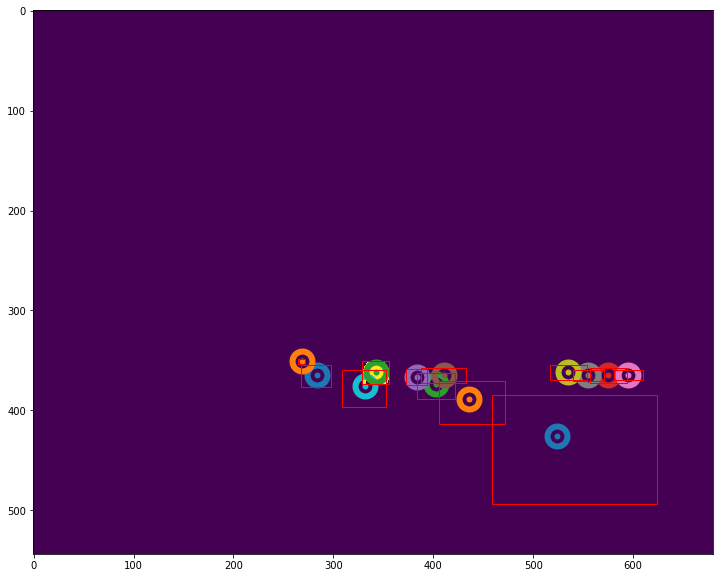

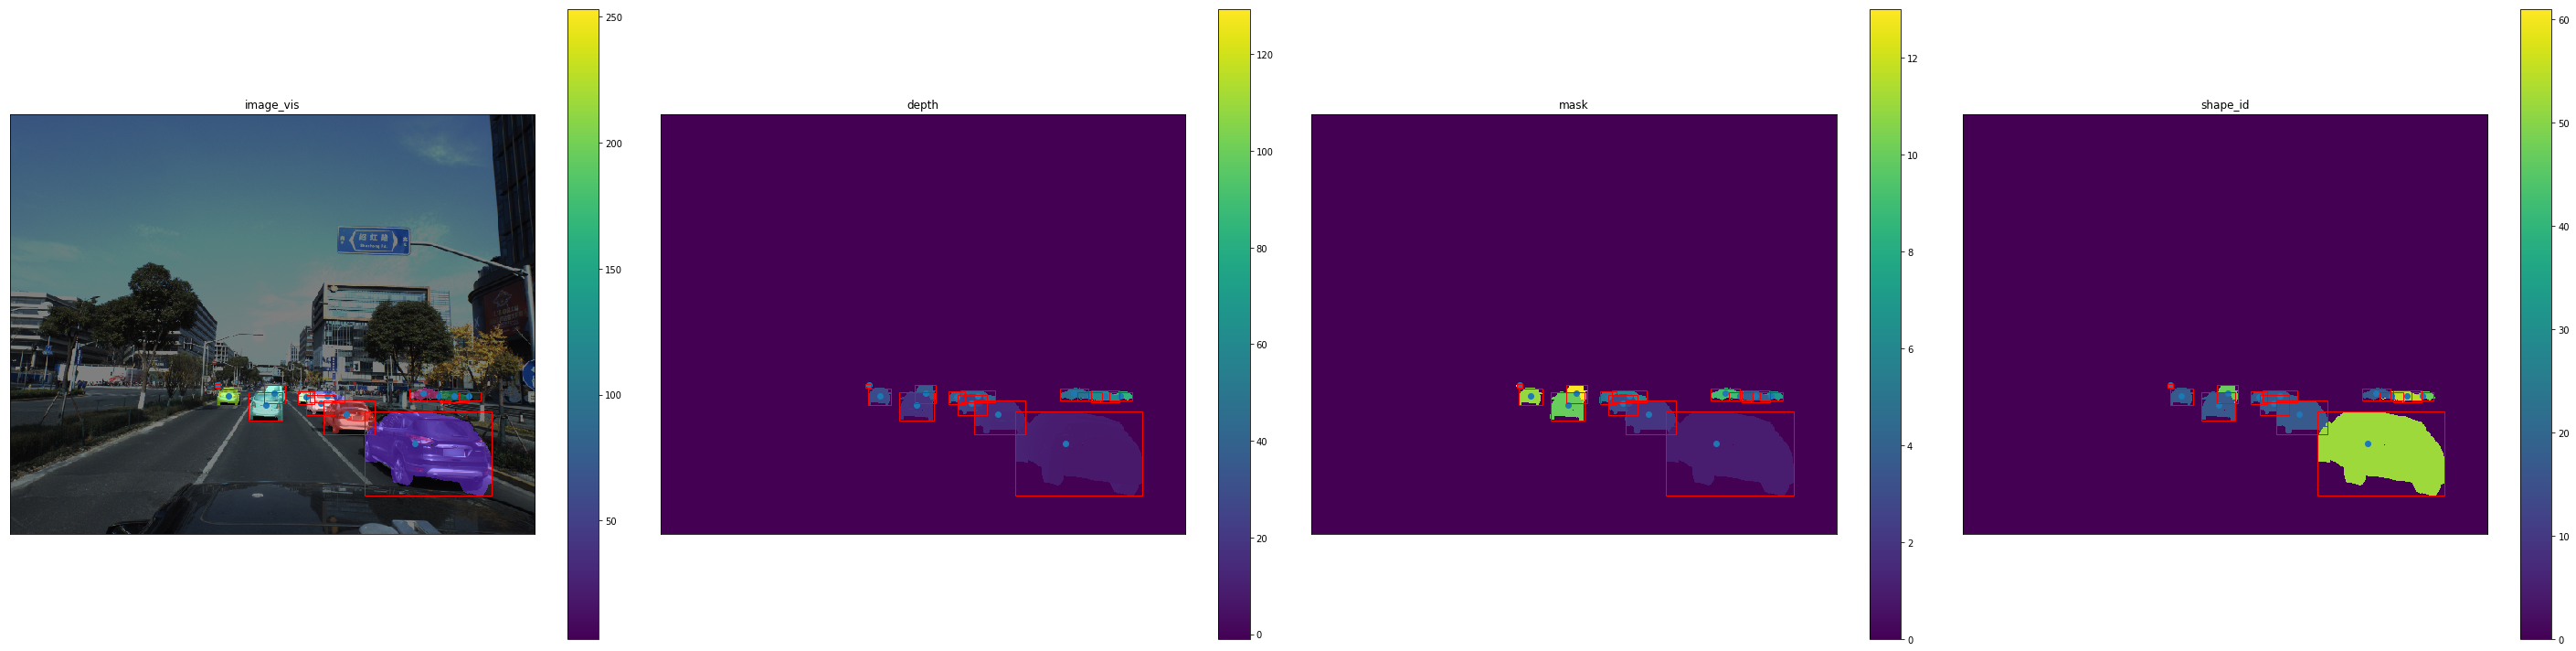

In [5]:
from PIL import Image
import h5py
import scipy.io as sio
import matplotlib.pyplot as plt
import utils.utils as uts
import pickle

%reload_ext autoreload
%autoreload 2
import render_car_instances as rci

sys.path[0] = '/home/zhurui/anaconda2/lib/python2.7/site-packages'
sys.path.insert(0, './renderer')

splits = ['train']
# splits = ['test']

for split in splits:
    Setting = namedtuple('Setting', ['data_dir'])
    setting = Setting('../apolloscape/combined/%s/'%split)

    visualizer = rci.CarPoseVisualizer(setting, scale=0.2, codes=codes)
    visualizer.load_car_models()
#     off_path = '/home/zhurui/Documents/mesh-voxelization/models/cars_64/2_watertight/'
#     visualizer.load_car_models_off(off_path)
    apollo_images_root = '/home/zhurui/Documents/baidu/personal-code/car-fitting/rui_modelfitting/dataset-api/apolloscape/combined/%s/images'%split
    print apollo_images_root
    search_files = os.path.join(apollo_images_root, pattern)
    filenames = sorted(glob.glob(search_files))
    print len(filenames)
    for file_idx, filename in enumerate(filenames):
        print '--- %d/%d...'%(file_idx, len(filenames))
        image_name = ntpath.basename(filename).replace('.jpg', '')
        folder_name = 'pose_maps_02'
        plot_path = filename.replace('images', folder_name).replace('.jpg', '_plot.jpg')
        
#         if os.path.isfile(filename.replace('images', folder_name).replace('.jpg', '_shape_id.png')):
# #             print 'Skipping '+filename
#             continue

        image_vis, seg_array, shape_id_map, depth, pose_map, image_rescaled, pose_list, shape_id_list, rot_uvd_list, bbox_list = \
            visualizer.showAnn(image_name, if_visualize=file_idx<10, if_save=False, plot_path=plot_path, is_training=True) 
        
#         image_rescaled = Image.fromarray(np.uint8(image_rescaled))
#         image_rescaled_name = filename.replace('images', folder_name).replace('.jpg', '_rescaled.png')
#         image_rescaled.save(image_rescaled_name)

#         image_vis = Image.fromarray(np.uint8(image_vis))
#         image_vis_name = filename.replace('images', folder_name).replace('.jpg', '_vis.png')
#         image_vis.save(image_vis_name)

#         seg = Image.fromarray(np.uint8(seg_array))
#         seg_name = filename.replace('images', folder_name).replace('.jpg', '_seg.png')
#         seg.save(seg_name)
        
#         shape_id = Image.fromarray(np.uint8(shape_id_map))
#         shape_id_name = filename.replace('images', folder_name).replace('.jpg', '_shape_id.png')
#         shape_id.save(shape_id_name)

#         pose_dict_path = filename.replace('images', folder_name).replace('.jpg', '_posedict.npy')
#         pose_list_array = np.asarray(pose_list)
#         np.save(pose_dict_path, np.float32(pose_list_array)) 

#         rot_uvd_dict_path = filename.replace('images', folder_name).replace('.jpg', '_rotuvddict.npy')
#         rot_uvd_list_array = np.asarray(rot_uvd_list)
#         np.save(rot_uvd_dict_path, np.float32(rot_uvd_list_array)) 
        
#         bbox_dict_path = filename.replace('images', folder_name).replace('.jpg', '_bboxdict.npy')
#         bbox_list_array = np.asarray(bbox_list)
#         np.save(bbox_dict_path, np.float32(bbox_list_array)) 

#         pose_list, shape_id_list = visualizer.showId(image_name)

#         shape_id_dict_path = filename.replace('images', folder_name).replace('.jpg', '_shapeiddict.npy')
#         shape_id_list_array = np.asarray(shape_id_list)
#         np.save(shape_id_dict_path, np.float32(shape_id_list_array)) 

#         if split == 'test':
#             masks_root = '/home/zhurui/Documents/baidu/personal-code/car-fitting/rui_modelfitting/dataset-api/apolloscape/combined/%s/det_masks'%split
#             mask_pkl = masks_root + '/%s.pkl'%image_name
#             with open(mask_pkl, 'rb') as f:
#                 mask = pickle.load(f)
#                 print len(mask[0])
            

        break

# Get lower half results

In [ ]:
def crop_half(image):
#     print image.shape
    if len(image.shape)==3:
        return image[image.shape[0]//2:, :, :]
    elif len(image.shape)==2:
        return image[image.shape[0]//2:, :]

splits = ['train']
# splits = ['test']

for split in splits:
    Setting = namedtuple('Setting', ['data_dir'])
    setting = Setting('../apolloscape/combined/%s/'%split)

    visualizer = rci.CarPoseVisualizer(setting, scale=0.2)
    visualizer.load_car_models()
    apollo_images_root = '/home/zhurui/Documents/baidu/personal-code/car-fitting/rui_modelfitting/dataset-api/apolloscape/combined/%s/images'%split
    search_files = os.path.join(apollo_images_root, pattern)
    filenames = sorted(glob.glob(search_files))
    print len(filenames)
    for file_idx, filename in enumerate(filenames):
        print '--- %d/%d...'%(file_idx, len(filenames))
        image_name = ntpath.basename(filename).replace('.jpg', '')
        folder_name = 'pose_maps_02_2'
        plot_path = filename.replace('images', folder_name).replace('.jpg', '_plot.jpg')
        
        for file_name in ['_rescaled.png', '_vis.png', '_seg.png', '_shape_id.png']: 
#         for file_name in ['_seg.png']: 
            image_name = filename.replace('images', folder_name).replace('.jpg', file_name)
            
            if os.path.isfile(image_name.replace('.png', '_half.png')):
                print 'Skipping '+filename
                continue
            
            print image_name
            im = plt.imread(image_name)
            half_im = np.uint8(crop_half(im)*255.)
            Image.fromarray(half_im).save(image_name.replace('.png', '_half.png'))

            print 'Saved to '+image_name.replace('.png', '_half.png')

    #     break

# Render 2d GT

In [ ]:
## from PIL import Image
import h5py
import scipy.io as sio
import matplotlib.pyplot as plt
import utils.utils as uts
import pickle

%reload_ext autoreload
%autoreload 2
import render_car_instances as rci

sys.path[0] = '/home/zhurui/anaconda2/lib/python2.7/site-packages'
sys.path.insert(0, './renderer')

splits = ['train']

for split in splits:
    Setting = namedtuple('Setting', ['data_dir'])
    setting = Setting('../apolloscape/combined/%s/'%split)

    visualizer = rci.CarPoseVisualizer(setting, scale=0.2, codes=codes)
    visualizer.load_car_models()
    apollo_images_root = '/home/zhurui/Documents/baidu/personal-code/car-fitting/rui_modelfitting/dataset-api/apolloscape/combined/%s/images'%split
    print apollo_images_root
    search_files = os.path.join(apollo_images_root, pattern)
    filenames = sorted(glob.glob(search_files))
    print len(filenames)
    for file_idx, filename in enumerate(filenames):
        print '--- %d/%d...'%(file_idx, len(filenames))
        image_name = ntpath.basename(filename).replace('.jpg', '')
        folder_name = 'pose_maps_02'
        plot_path = filename.replace('images', folder_name).replace('.jpg', '_plot.jpg')
        
        image_vis, seg_array, shape_id_map, depth, pose_map, image_rescaled, pose_list, shape_id_list, _ = \
            visualizer.showAnn(image_name, if_visualize=True, if_save=False, plot_path=plot_path, is_training=True) 

        break

# Get pose dict stastics

In [15]:
from PIL import Image
import h5py
import scipy.io as sio
import matplotlib.pyplot as plt
import utils.utils as uts
import pickle

%reload_ext autoreload
%autoreload 2
import render_car_instances as rci

sys.path[0] = '/home/zhurui/anaconda2/lib/python2.7/site-packages'
sys.path.insert(0, './renderer')

splits = ['train']
# splits = ['test']

max_num = 0
num_list = []

for split in splits:
    Setting = namedtuple('Setting', ['data_dir'])
    setting = Setting('../apolloscape/combined/%s/'%split)

    visualizer = rci.CarPoseVisualizer(setting, scale=0.2, codes=codes)
    visualizer.load_car_models()
#     off_path = '/home/zhurui/Documents/mesh-voxelization/models/cars_64/2_watertight/'
#     visualizer.load_car_models_off(off_path)
    apollo_images_root = '/home/zhurui/Documents/baidu/personal-code/car-fitting/rui_modelfitting/dataset-api/apolloscape/combined/%s/images'%split
    print apollo_images_root
    search_files = os.path.join(apollo_images_root, pattern)
    filenames = sorted(glob.glob(search_files))
    print len(filenames)
    
    rot_uvd_dict_list = []
    pose_dict_list = []
    for file_idx, filename in enumerate(filenames):
        print '--- %d/%d...'%(file_idx, len(filenames))
        image_name = ntpath.basename(filename).replace('.jpg', '')
        folder_name = 'pose_maps_02_2'
        plot_path = filename.replace('images', folder_name).replace('.jpg', '_plot.jpg')
        
        rot_uvd_dict_path = filename.replace('images', folder_name).replace('.jpg', '_rotuvddict.npy')
        rot_uvd_dict = np.load(rot_uvd_dict_path)
        rot_uvd_dict_list.append(rot_uvd_dict)
        
        pose_dict_path = filename.replace('images', folder_name).replace('.jpg', '_posedict.npy')
        pose_dict = np.load(pose_dict_path)
        pose_dict_list.append(pose_dict)
        
        max_num = max(max_num, pose_dict.shape[0])
        num_list.append(pose_dict.shape[0])
        
rot_uvd_dict_all = np.concatenate(rot_uvd_dict_list)
pose_dict_all = np.concatenate(pose_dict_list)

INFO:root:loading 79 car models from ../apolloscape/combined/train//car_models...


/home/zhurui/Documents/baidu/personal-code/car-fitting/rui_modelfitting/dataset-api/apolloscape/combined/train/images
5091
--- 0/5091...
--- 1/5091...
--- 2/5091...
--- 3/5091...
--- 4/5091...
--- 5/5091...
--- 6/5091...
--- 7/5091...
--- 8/5091...
--- 9/5091...
--- 10/5091...
--- 11/5091...
--- 12/5091...
--- 13/5091...
--- 14/5091...
--- 15/5091...
--- 16/5091...
--- 17/5091...
--- 18/5091...
--- 19/5091...
--- 20/5091...
--- 21/5091...
--- 22/5091...
--- 23/5091...
--- 24/5091...
--- 25/5091...
--- 26/5091...
--- 27/5091...
--- 28/5091...
--- 29/5091...
--- 30/5091...
--- 31/5091...
--- 32/5091...
--- 33/5091...
--- 34/5091...
--- 35/5091...
--- 36/5091...
--- 37/5091...
--- 38/5091...
--- 39/5091...
--- 40/5091...
--- 41/5091...
--- 42/5091...
--- 43/5091...
--- 44/5091...
--- 45/5091...
--- 46/5091...
--- 47/5091...
--- 48/5091...
--- 49/5091...
--- 50/5091...
--- 51/5091...
--- 52/5091...
--- 53/5091...
--- 54/5091...
--- 55/5091...
--- 56/5091...
--- 57/5091...
--- 58/5091...
--

--- 542/5091...
--- 543/5091...
--- 544/5091...
--- 545/5091...
--- 546/5091...
--- 547/5091...
--- 548/5091...
--- 549/5091...
--- 550/5091...
--- 551/5091...
--- 552/5091...
--- 553/5091...
--- 554/5091...
--- 555/5091...
--- 556/5091...
--- 557/5091...
--- 558/5091...
--- 559/5091...
--- 560/5091...
--- 561/5091...
--- 562/5091...
--- 563/5091...
--- 564/5091...
--- 565/5091...
--- 566/5091...
--- 567/5091...
--- 568/5091...
--- 569/5091...
--- 570/5091...
--- 571/5091...
--- 572/5091...
--- 573/5091...
--- 574/5091...
--- 575/5091...
--- 576/5091...
--- 577/5091...
--- 578/5091...
--- 579/5091...
--- 580/5091...
--- 581/5091...
--- 582/5091...
--- 583/5091...
--- 584/5091...
--- 585/5091...
--- 586/5091...
--- 587/5091...
--- 588/5091...
--- 589/5091...
--- 590/5091...
--- 591/5091...
--- 592/5091...
--- 593/5091...
--- 594/5091...
--- 595/5091...
--- 596/5091...
--- 597/5091...
--- 598/5091...
--- 599/5091...
--- 600/5091...
--- 601/5091...
--- 602/5091...
--- 603/5091...
--- 604/

--- 1116/5091...
--- 1117/5091...
--- 1118/5091...
--- 1119/5091...
--- 1120/5091...
--- 1121/5091...
--- 1122/5091...
--- 1123/5091...
--- 1124/5091...
--- 1125/5091...
--- 1126/5091...
--- 1127/5091...
--- 1128/5091...
--- 1129/5091...
--- 1130/5091...
--- 1131/5091...
--- 1132/5091...
--- 1133/5091...
--- 1134/5091...
--- 1135/5091...
--- 1136/5091...
--- 1137/5091...
--- 1138/5091...
--- 1139/5091...
--- 1140/5091...
--- 1141/5091...
--- 1142/5091...
--- 1143/5091...
--- 1144/5091...
--- 1145/5091...
--- 1146/5091...
--- 1147/5091...
--- 1148/5091...
--- 1149/5091...
--- 1150/5091...
--- 1151/5091...
--- 1152/5091...
--- 1153/5091...
--- 1154/5091...
--- 1155/5091...
--- 1156/5091...
--- 1157/5091...
--- 1158/5091...
--- 1159/5091...
--- 1160/5091...
--- 1161/5091...
--- 1162/5091...
--- 1163/5091...
--- 1164/5091...
--- 1165/5091...
--- 1166/5091...
--- 1167/5091...
--- 1168/5091...
--- 1169/5091...
--- 1170/5091...
--- 1171/5091...
--- 1172/5091...
--- 1173/5091...
--- 1174/5091.

--- 1688/5091...
--- 1689/5091...
--- 1690/5091...
--- 1691/5091...
--- 1692/5091...
--- 1693/5091...
--- 1694/5091...
--- 1695/5091...
--- 1696/5091...
--- 1697/5091...
--- 1698/5091...
--- 1699/5091...
--- 1700/5091...
--- 1701/5091...
--- 1702/5091...
--- 1703/5091...
--- 1704/5091...
--- 1705/5091...
--- 1706/5091...
--- 1707/5091...
--- 1708/5091...
--- 1709/5091...
--- 1710/5091...
--- 1711/5091...
--- 1712/5091...
--- 1713/5091...
--- 1714/5091...
--- 1715/5091...
--- 1716/5091...
--- 1717/5091...
--- 1718/5091...
--- 1719/5091...
--- 1720/5091...
--- 1721/5091...
--- 1722/5091...
--- 1723/5091...
--- 1724/5091...
--- 1725/5091...
--- 1726/5091...
--- 1727/5091...
--- 1728/5091...
--- 1729/5091...
--- 1730/5091...
--- 1731/5091...
--- 1732/5091...
--- 1733/5091...
--- 1734/5091...
--- 1735/5091...
--- 1736/5091...
--- 1737/5091...
--- 1738/5091...
--- 1739/5091...
--- 1740/5091...
--- 1741/5091...
--- 1742/5091...
--- 1743/5091...
--- 1744/5091...
--- 1745/5091...
--- 1746/5091.

--- 2260/5091...
--- 2261/5091...
--- 2262/5091...
--- 2263/5091...
--- 2264/5091...
--- 2265/5091...
--- 2266/5091...
--- 2267/5091...
--- 2268/5091...
--- 2269/5091...
--- 2270/5091...
--- 2271/5091...
--- 2272/5091...
--- 2273/5091...
--- 2274/5091...
--- 2275/5091...
--- 2276/5091...
--- 2277/5091...
--- 2278/5091...
--- 2279/5091...
--- 2280/5091...
--- 2281/5091...
--- 2282/5091...
--- 2283/5091...
--- 2284/5091...
--- 2285/5091...
--- 2286/5091...
--- 2287/5091...
--- 2288/5091...
--- 2289/5091...
--- 2290/5091...
--- 2291/5091...
--- 2292/5091...
--- 2293/5091...
--- 2294/5091...
--- 2295/5091...
--- 2296/5091...
--- 2297/5091...
--- 2298/5091...
--- 2299/5091...
--- 2300/5091...
--- 2301/5091...
--- 2302/5091...
--- 2303/5091...
--- 2304/5091...
--- 2305/5091...
--- 2306/5091...
--- 2307/5091...
--- 2308/5091...
--- 2309/5091...
--- 2310/5091...
--- 2311/5091...
--- 2312/5091...
--- 2313/5091...
--- 2314/5091...
--- 2315/5091...
--- 2316/5091...
--- 2317/5091...
--- 2318/5091.

--- 2815/5091...
--- 2816/5091...
--- 2817/5091...
--- 2818/5091...
--- 2819/5091...
--- 2820/5091...
--- 2821/5091...
--- 2822/5091...
--- 2823/5091...
--- 2824/5091...
--- 2825/5091...
--- 2826/5091...
--- 2827/5091...
--- 2828/5091...
--- 2829/5091...
--- 2830/5091...
--- 2831/5091...
--- 2832/5091...
--- 2833/5091...
--- 2834/5091...
--- 2835/5091...
--- 2836/5091...
--- 2837/5091...
--- 2838/5091...
--- 2839/5091...
--- 2840/5091...
--- 2841/5091...
--- 2842/5091...
--- 2843/5091...
--- 2844/5091...
--- 2845/5091...
--- 2846/5091...
--- 2847/5091...
--- 2848/5091...
--- 2849/5091...
--- 2850/5091...
--- 2851/5091...
--- 2852/5091...
--- 2853/5091...
--- 2854/5091...
--- 2855/5091...
--- 2856/5091...
--- 2857/5091...
--- 2858/5091...
--- 2859/5091...
--- 2860/5091...
--- 2861/5091...
--- 2862/5091...
--- 2863/5091...
--- 2864/5091...
--- 2865/5091...
--- 2866/5091...
--- 2867/5091...
--- 2868/5091...
--- 2869/5091...
--- 2870/5091...
--- 2871/5091...
--- 2872/5091...
--- 2873/5091.

--- 3379/5091...
--- 3380/5091...
--- 3381/5091...
--- 3382/5091...
--- 3383/5091...
--- 3384/5091...
--- 3385/5091...
--- 3386/5091...
--- 3387/5091...
--- 3388/5091...
--- 3389/5091...
--- 3390/5091...
--- 3391/5091...
--- 3392/5091...
--- 3393/5091...
--- 3394/5091...
--- 3395/5091...
--- 3396/5091...
--- 3397/5091...
--- 3398/5091...
--- 3399/5091...
--- 3400/5091...
--- 3401/5091...
--- 3402/5091...
--- 3403/5091...
--- 3404/5091...
--- 3405/5091...
--- 3406/5091...
--- 3407/5091...
--- 3408/5091...
--- 3409/5091...
--- 3410/5091...
--- 3411/5091...
--- 3412/5091...
--- 3413/5091...
--- 3414/5091...
--- 3415/5091...
--- 3416/5091...
--- 3417/5091...
--- 3418/5091...
--- 3419/5091...
--- 3420/5091...
--- 3421/5091...
--- 3422/5091...
--- 3423/5091...
--- 3424/5091...
--- 3425/5091...
--- 3426/5091...
--- 3427/5091...
--- 3428/5091...
--- 3429/5091...
--- 3430/5091...
--- 3431/5091...
--- 3432/5091...
--- 3433/5091...
--- 3434/5091...
--- 3435/5091...
--- 3436/5091...
--- 3437/5091.

--- 3935/5091...
--- 3936/5091...
--- 3937/5091...
--- 3938/5091...
--- 3939/5091...
--- 3940/5091...
--- 3941/5091...
--- 3942/5091...
--- 3943/5091...
--- 3944/5091...
--- 3945/5091...
--- 3946/5091...
--- 3947/5091...
--- 3948/5091...
--- 3949/5091...
--- 3950/5091...
--- 3951/5091...
--- 3952/5091...
--- 3953/5091...
--- 3954/5091...
--- 3955/5091...
--- 3956/5091...
--- 3957/5091...
--- 3958/5091...
--- 3959/5091...
--- 3960/5091...
--- 3961/5091...
--- 3962/5091...
--- 3963/5091...
--- 3964/5091...
--- 3965/5091...
--- 3966/5091...
--- 3967/5091...
--- 3968/5091...
--- 3969/5091...
--- 3970/5091...
--- 3971/5091...
--- 3972/5091...
--- 3973/5091...
--- 3974/5091...
--- 3975/5091...
--- 3976/5091...
--- 3977/5091...
--- 3978/5091...
--- 3979/5091...
--- 3980/5091...
--- 3981/5091...
--- 3982/5091...
--- 3983/5091...
--- 3984/5091...
--- 3985/5091...
--- 3986/5091...
--- 3987/5091...
--- 3988/5091...
--- 3989/5091...
--- 3990/5091...
--- 3991/5091...
--- 3992/5091...
--- 3993/5091.

--- 4496/5091...
--- 4497/5091...
--- 4498/5091...
--- 4499/5091...
--- 4500/5091...
--- 4501/5091...
--- 4502/5091...
--- 4503/5091...
--- 4504/5091...
--- 4505/5091...
--- 4506/5091...
--- 4507/5091...
--- 4508/5091...
--- 4509/5091...
--- 4510/5091...
--- 4511/5091...
--- 4512/5091...
--- 4513/5091...
--- 4514/5091...
--- 4515/5091...
--- 4516/5091...
--- 4517/5091...
--- 4518/5091...
--- 4519/5091...
--- 4520/5091...
--- 4521/5091...
--- 4522/5091...
--- 4523/5091...
--- 4524/5091...
--- 4525/5091...
--- 4526/5091...
--- 4527/5091...
--- 4528/5091...
--- 4529/5091...
--- 4530/5091...
--- 4531/5091...
--- 4532/5091...
--- 4533/5091...
--- 4534/5091...
--- 4535/5091...
--- 4536/5091...
--- 4537/5091...
--- 4538/5091...
--- 4539/5091...
--- 4540/5091...
--- 4541/5091...
--- 4542/5091...
--- 4543/5091...
--- 4544/5091...
--- 4545/5091...
--- 4546/5091...
--- 4547/5091...
--- 4548/5091...
--- 4549/5091...
--- 4550/5091...
--- 4551/5091...
--- 4552/5091...
--- 4553/5091...
--- 4554/5091.

--- 5067/5091...
--- 5068/5091...
--- 5069/5091...
--- 5070/5091...
--- 5071/5091...
--- 5072/5091...
--- 5073/5091...
--- 5074/5091...
--- 5075/5091...
--- 5076/5091...
--- 5077/5091...
--- 5078/5091...
--- 5079/5091...
--- 5080/5091...
--- 5081/5091...
--- 5082/5091...
--- 5083/5091...
--- 5084/5091...
--- 5085/5091...
--- 5086/5091...
--- 5087/5091...
--- 5088/5091...
--- 5089/5091...
--- 5090/5091...


In [8]:
# print rot_uvd_dict_all.shape, bbox_dict_all.shape
# bbox_c_dict_all = np.stack(((bbox_dict_all[:, 0]+bbox_dict_all[:, 1])/2, (bbox_dict_all[:, 2]+bbox_dict_all[:, 3])/2), axis=1)
# uv_offset_dict_all = np.stack((rot_uvd_dict_all[:, 3]-bbox_c_dict_all[:, 0], rot_uvd_dict_all[:, 4]-bbox_c_dict_all[:, 1]), axis=1)

# print uv_offset_dict_all[:20, :], np.max(uv_offset_dict_all, axis=0)

import scipy.io as sio

sio.savemat('/home/zhurui/Documents/baidu/personal-code/car-fitting/rui_modelfitting/dataset-api/apolloscape/combined/rot_uvd_dict_all.mat', {'a':rot_uvd_dict_all})
sio.savemat('/home/zhurui/Documents/baidu/personal-code/car-fitting/rui_modelfitting/dataset-api/apolloscape/combined/pose_dict_all.mat', {'a':pose_dict_all})
# sio.savemat('/home/zhurui/Documents/baidu/personal-code/car-fitting/rui_modelfitting/dataset-api/apolloscape/combined/uv_offset_dict_all.mat', {'a':uv_offset_dict_all})
# sio.savemat('/home/zhurui/Documents/baidu/personal-code/car-fitting/rui_modelfitting/dataset-api/apolloscape/combined/bbox_c_dict_all.mat', {'a':bbox_c_dict_all})

In [13]:
np.max(rot_uvd_dict_all[:, 3:5])

907.13513

49


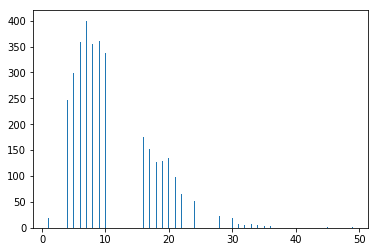

In [19]:
print max_num
plt.hist(num_list, bins=500)
plt.show()